# Modelovanie č. 1 - klasifikačné metódy


## Načítanie knižníc

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


## Načítanie dát

In [2]:
with open('data/Train_data_preprocessed.pkl', 'rb') as file:
    data = pickle.load(file)

## Rozdelenie dát na trénovacie a testovacie

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['class']), data['class'], test_size=0.3, random_state=42)

## Normalizácia dát pomocou StandardScaler

In [4]:
quantitative = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train[quantitative])
X_test = scaler.transform(X_test[quantitative])

## Modelovanie

In [5]:
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

rf.fit(X_train, y_train)
knn.fit(X_train, y_train)

models = (
    ('Random Forest', rf),
    ('KNN', knn)
)

## Vyhodnotenie modelov

Random Forest Specificity: 0.9986
Random Forest Accuracy: 0.9963


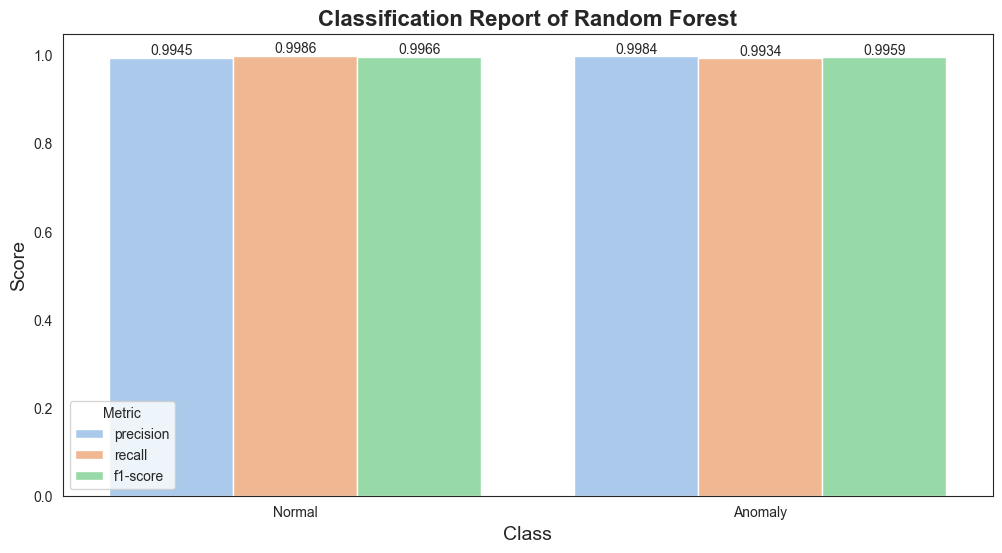

KNN Specificity: 0.9953
KNN Accuracy: 0.9928


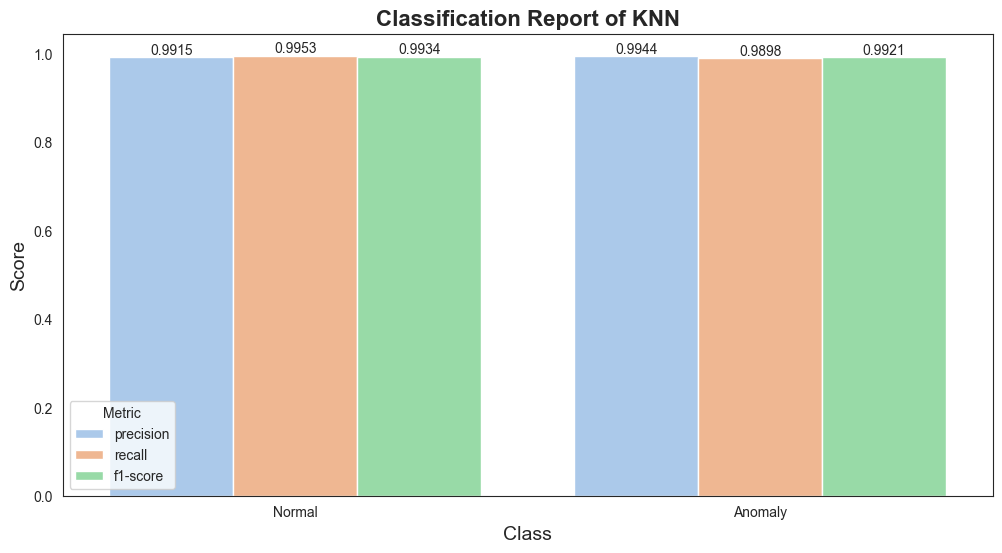

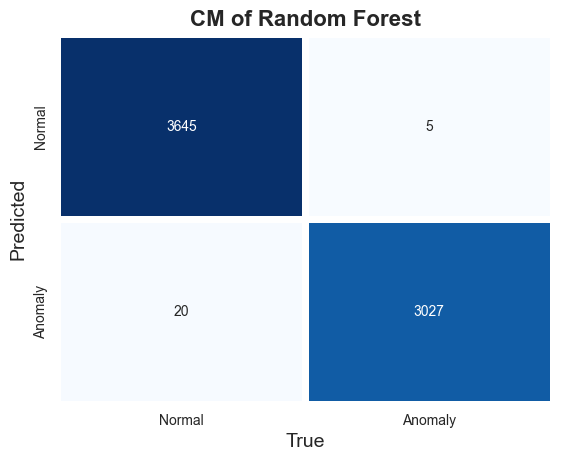

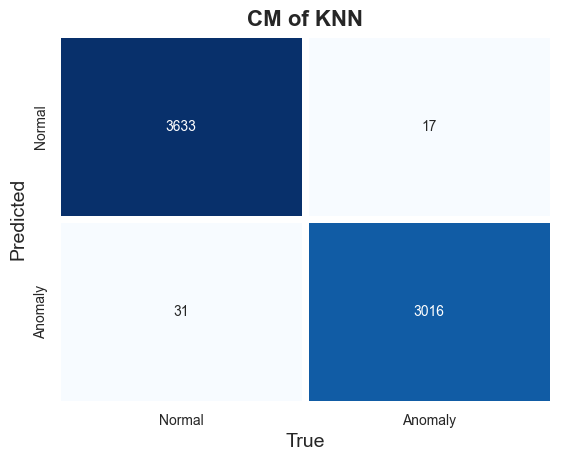

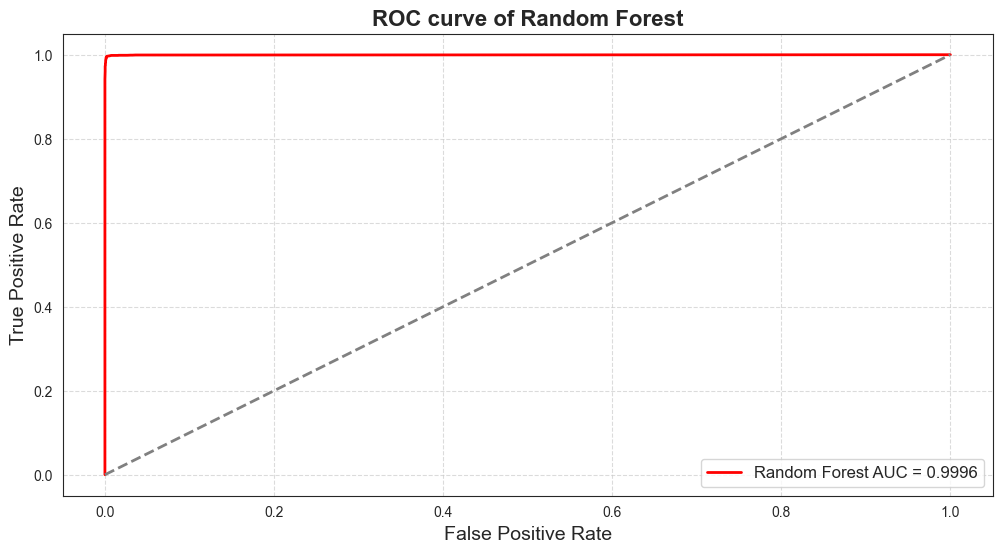

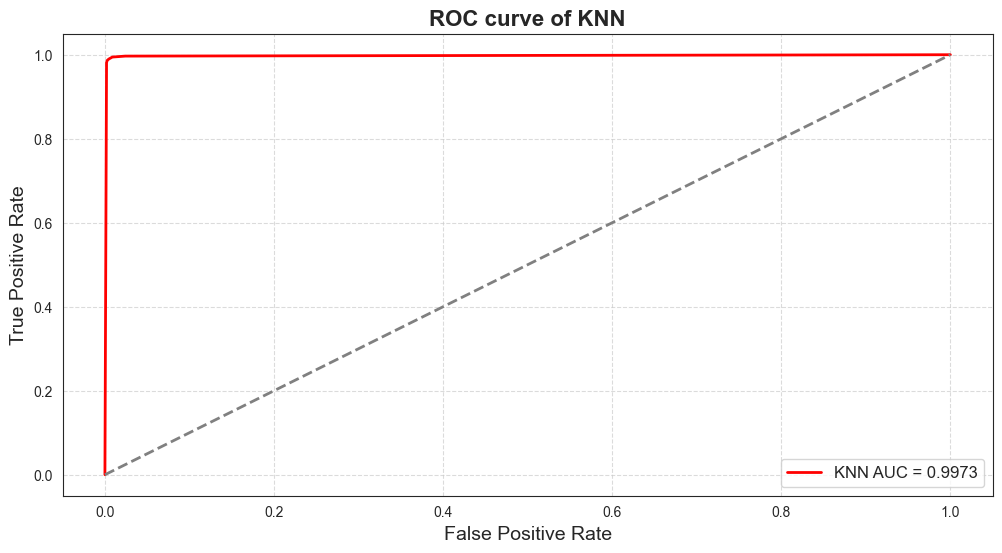

In [6]:
sns.set_style("white")

target_names = ["Normal", "Anomaly"]

for name, model in models:
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    print(f"{name} Specificity: {specificity:.4f}")
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose().reset_index()

    report_melted = report_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], var_name='metric', value_name='score')
    report_melted = report_melted[~report_melted['index'].isin(['macro avg', 'weighted avg', 'accuracy'])]

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='index', y='score', hue='metric', data=report_melted, palette='pastel')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')

    plt.title(f'Classification Report of {name}', fontsize=16, fontweight='bold')
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.legend(title='Metric')
    plt.show()

for name, model in models:
    sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot=True, cmap='Blues', linewidths=5, fmt='d', xticklabels=target_names, yticklabels=target_names, cbar=False)
    plt.title(f'CM of {name}', fontsize=16, fontweight='bold')
    plt.xlabel('True', fontsize=14)
    plt.ylabel('Predicted', fontsize=14)
    plt.show()

for name, model in models:
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, label=f'{name} AUC = {roc_auc:.4f}', color='red', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'ROC curve of {name}', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    